In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# 1. Inspecting the data

In [2]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Comparing survival rate across various categorical variables

In [3]:
for col in train_data.columns[[2,4,6,7,11]]:
    print(train_data.groupby(col,as_index=False)["Survived"].mean(),"\n\n")

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363 


      Sex  Survived
0  female  0.742038
1    male  0.188908 


   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000 


   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000 


  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957 




### Comparing survival rate across age groups

Text(0, 0.5, 'Survival Rate')

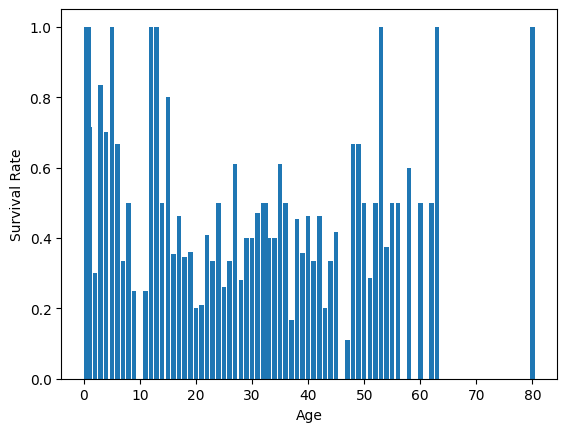

In [4]:
average_survival_rate_per_age = train_data.groupby("Age",as_index=False)["Survived"].mean()
plt.bar(average_survival_rate_per_age['Age'],average_survival_rate_per_age['Survived'])

plt.xlabel('Age')
plt.ylabel('Survival Rate')

### Comparing survival rate across fare groups

Text(0, 0.5, 'Survival Rate')

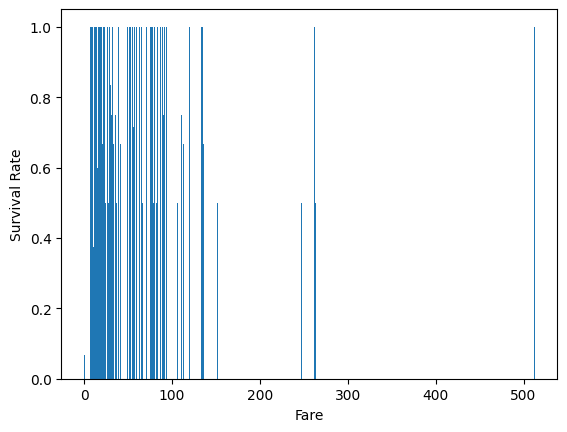

In [5]:
average_survival_rate_per_fare_group = train_data.groupby("Fare",as_index=False)["Survived"].mean()
plt.bar(average_survival_rate_per_fare_group['Fare'],average_survival_rate_per_fare_group['Survived'])

plt.xlabel('Fare')
plt.ylabel('Survival Rate')

# 2. Training a simple random forest

In [5]:
train_data['is_male'] = pd.get_dummies(train_data['Sex'],drop_first=True)
test_data['is_male'] = pd.get_dummies(test_data['Sex'],drop_first=True)

features = ['Age', 'is_male', 'Fare', 'Pclass', 'SibSp', 'Parch']

X_train = train_data[features]
X_test = test_data[features]
y = train_data["Survived"]

### Writing in pipes

In [15]:
# 1. Define the pipeline
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('random_forest', RandomForestClassifier(
        n_estimators=1000,
        random_state=1
    ))
])

# 2. Set up the grid of hyperparameters to search
param_grid = {
    'random_forest__max_depth':        [3, 5, 7, 9, None],
    'random_forest__min_samples_leaf': [5, 10, 15],
    'random_forest__class_weight':     [None, 'balanced', 'balanced_subsample',
                                        {0: 1, 1: 1.5}, {0: 1, 1: 2}]  # example custom mapping
}

# 3. Create the GridSearchCV object
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', 
    n_jobs=-1,          # use all cores
    verbose=1
)

# 4. Fit to the training data
predictions = grid.fit(X_train, y).predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('sumbissions/submission_RF.csv', index=False)

# 5. Inspect the best parameters and best score
print("Best max_depth:", grid.best_params_['random_forest__max_depth'])
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best max_depth: 9
Best CV accuracy: 0.8227229929069111


##### Interpreting

   Feature  Importance
0  is_male    0.439106
1     Fare    0.214155
2      Age    0.138183
3   Pclass    0.130200
4    SibSp    0.046652
5    Parch    0.031704


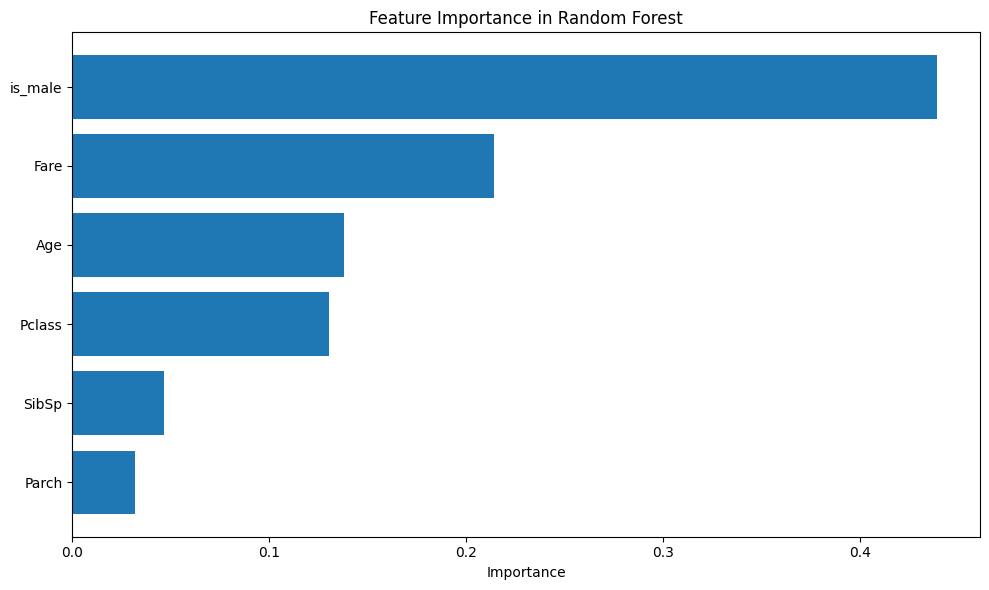

In [16]:
# 1. After grid search, get the best pipeline
best_pipe = grid.best_estimator_

# 2. Extract the trained RandomForestClassifier
rf = best_pipe.named_steps['random_forest']

# 3. Get importances
importances = rf.feature_importances_

# 4. Get the feature names
#    If you only impute (don’t add/drop or encode columns), your original X_train.columns still apply:
feature_names = X_train.columns

#    If you had a more complex pipeline (e.g. one-hot encoding via ColumnTransformer),
#    you’d use something like:
# feature_names = best_pipe.named_steps['preprocessor'] \
#                   .get_feature_names_out(input_features=X_train.columns)

# 5. Build a DataFrame and sort
feature_importance_df = (
    pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

# 6. Display the top features
print(feature_importance_df)

# 7. Plot
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'],
    feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()